#**DEEP LEARNING - Tamil Character Classification**


### **Uploading the data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile  # unziping 
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
# 1. Unzip images
path = '/content/dataset.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/image_data')

### **Converting images to .jpeg format from .tiff**

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

os.makedirs('/content/jpg_data')

for files in  os.listdir("/content/image_data/shuffled"):
    im = Image.open('/content/image_data/shuffled/'+str(files))
    im.save('/content/jpg_data/'+str(files).replace(".tiff","")+'.jpeg')

###**Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from PIL import Image

datagen = ImageDataGenerator(
            width_shift_range=0.2,  
            height_shift_range=0.2,           
            zoom_range=0.2)

image_directory = '/content/55/'
SIZE = 224
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
   if (image_name.split('.')[1] == 'jpg'):        
       image = io.imread(image_directory + image_name)        
       image = Image.fromarray(image, 'RGB')        
       image = image.resize((SIZE,SIZE)) 
       dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/jpg_data/',
                          save_prefix='u55_155t',
                          save_format='jpeg'):    
  i += 1    
  if i > 20:        
     break

###**Resizing all images into the same size**

In [ ]:
os.makedirs('/content/processed_img')

for fil in  os.listdir("/content/jpg_data"):
    img=cv2.imread('/content/jpg_data/'+str(fil))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2=255-img
    img2=cv2.resize(img2, (224, 224))
    cv2.imwrite("/content/processed_img/"+str(fil), img2)

###**Classifying the dataset and storing in folders**

In [ ]:
import re
os.makedirs('/content/classified_dataset')

for files in  os.listdir("/content/processed_img"):
    index1=re.findall(r'\d\dt',files)
    index=int(index1[0][0:2])
    img=cv2.imread('/content/processed_img/'+str(files),0)
    #print(index)
    if not os.path.exists('/content/classified_dataset/'+str(index)+'/'):
        os.makedirs('/content/classified_dataset/'+str(index)+'/')
    cv2.imwrite('/content/classified_dataset/'+str(index)+'/'+files,img)


### **CNN model**

In [ ]:
images=[]
labels=[]
for folders in os.listdir('/content/classified_dataset'):
    for files in os.listdir('/content/classified_dataset/'+folders):
        img=cv2.imread('/content/classified_dataset/'+folders+'/'+files,0)/255
        img=cv2.resize(img,(128,128))
        img.shape=(128,128,1)
        images.append(img)
        labels.append(folders)
images=np.array(images)
labels=np.array(labels)

In [ ]:
len(os.listdir("/content/jpg_data"))

1456

###**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_labels = onehot_encoder.fit_transform(integer_encoded)

In [ ]:
label_encoder.classes_

array(['10', '55', '6', '7', '8', '9'], dtype='<U2')

### **Train test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y_labels, test_size=0.33, random_state=42)

In [ ]:
len(X_train)

975

In [ ]:
len(X_test)

481

###**Architecture 1**

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (5, 5), input_shape=(128,128,1), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(16, (5, 5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(16, (5, 5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(6, activation='softmax'))
model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 16)        12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 16)        0

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=75, verbose=1)
scores1 = model1.evaluate(images, y_labels, verbose=1)
print("CNN Error: %.2f%%" % (100-scores1[1]*100))

Epoch 1/15
13/13 [==============================] - 29s 2s/step - loss: 1.3881 - accuracy: 0.4451 - val_loss: 0.7665 - val_accuracy: 0.7256
Epoch 2/15
13/13 [==============================] - 27s 2s/step - loss: 0.6490 - accuracy: 0.7651 - val_loss: 0.4767 - val_accuracy: 0.8399
Epoch 3/15
13/13 [==============================] - 27s 2s/step - loss: 0.3984 - accuracy: 0.8564 - val_loss: 0.3380 - val_accuracy: 0.8877
Epoch 4/15
13/13 [==============================] - 27s 2s/step - loss: 0.2464 - accuracy: 0.9128 - val_loss: 0.2825 - val_accuracy: 0.9085
Epoch 5/15
13/13 [==============================] - 27s 2s/step - loss: 0.1461 - accuracy: 0.9569 - val_loss: 0.2235 - val_accuracy: 0.9293
Epoch 6/15
13/13 [==============================] - 27s 2s/step - loss: 0.1067 - accuracy: 0.9631 - val_loss: 0.2267 - val_accuracy: 0.9314
Epoch 7/15
13/13 [==============================] - 27s 2s/step - loss: 0.0726 - accuracy: 0.9723 - val_loss: 0.4023 - val_accuracy: 0.8940
Epoch 8/15
13/13 [==

###**Architecture 2**

In [ ]:
model2 = Sequential()
model2.add(Conv2D(128, (3, 3), input_shape=(128,128,1),padding='valid',strides=(1,1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(6, activation='softmax'))
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)       

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=13, batch_size=100, verbose=1)
scores2 = model2.evaluate(images, y_labels, verbose=1)
print("CNN Error: %.2f%%" % (100-scores2[1]*100))

Epoch 1/13
10/10 [==============================] - 80s 8s/step - loss: 1.1285 - accuracy: 0.5733 - val_loss: 0.6703 - val_accuracy: 0.7443
Epoch 2/13
10/10 [==============================] - 77s 8s/step - loss: 0.5062 - accuracy: 0.8297 - val_loss: 0.3731 - val_accuracy: 0.8690
Epoch 3/13
10/10 [==============================] - 76s 8s/step - loss: 0.2811 - accuracy: 0.8892 - val_loss: 0.3512 - val_accuracy: 0.8836
Epoch 4/13
10/10 [==============================] - 76s 8s/step - loss: 0.1536 - accuracy: 0.9467 - val_loss: 0.2779 - val_accuracy: 0.9106
Epoch 5/13
10/10 [==============================] - 76s 8s/step - loss: 0.0853 - accuracy: 0.9692 - val_loss: 0.2943 - val_accuracy: 0.9085
Epoch 6/13
10/10 [==============================] - 77s 8s/step - loss: 0.0416 - accuracy: 0.9826 - val_loss: 0.3054 - val_accuracy: 0.9189
Epoch 7/13
10/10 [==============================] - 80s 8s/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.4448 - val_accuracy: 0.9148
Epoch 8/13
10/10 [==

###**Architecture 3**

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (5, 5), activation='relu', strides=(2, 2), padding='same', input_shape=(128, 128, 1)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(50, (5, 5), activation='relu', padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))   
model3.add(Conv2D(70, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))              
model3.add(Dropout(0.1))
model3.add(Dense(6, activation='softmax'))
model3.summary()
model3.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 50)        40050     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 70)        31570     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 70)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4480)             

In [ ]:
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100, verbose=1)
scores3 = model3.evaluate(images, y_labels, verbose=1)
print("CNN Error: %.2f%%" % (100-scores3[1]*100))

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 0.4860 - accuracy: 0.3169 - val_loss: 0.3350 - val_accuracy: 0.5177
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 0.2826 - accuracy: 0.6421 - val_loss: 0.2021 - val_accuracy: 0.8170
Epoch 3/15
10/10 [==============================] - 14s 1s/step - loss: 0.1931 - accuracy: 0.7897 - val_loss: 0.1214 - val_accuracy: 0.8815
Epoch 4/15
10/10 [==============================] - 14s 1s/step - loss: 0.1481 - accuracy: 0.8667 - val_loss: 0.1343 - val_accuracy: 0.8503
Epoch 5/15
10/10 [==============================] - 14s 1s/step - loss: 0.1149 - accuracy: 0.8903 - val_loss: 0.0831 - val_accuracy: 0.9106
Epoch 6/15
10/10 [==============================] - 14s 1s/step - loss: 0.0995 - accuracy: 0.9005 - val_loss: 0.0800 - val_accuracy: 0.9252
Epoch 7/15
10/10 [==============================] - 14s 1s/step - loss: 0.0691 - accuracy: 0.9374 - val_loss: 0.0648 - val_accuracy: 0.9314
Epoch 8/15
10/10 [==

###**Architecture 4**

In [ ]:
model4 = Sequential()
model4.add(Conv2D(128, (5, 5), activation='relu',  padding='valid', input_shape=(128, 128, 1)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(64, (5, 5), activation='relu', padding='valid'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(16, (3, 3), activation='relu', padding='valid'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Flatten())
model4.add(Dense(100, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(6, activation='sigmoid'))
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 124, 124, 128)     3328      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 58, 58, 64)        204864    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 27, 27, 32)        18464     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 16)       

In [ ]:
model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=150, verbose=1)
scores4 = model4.evaluate(images, y_labels, verbose=1)
print("CNN Error: %.2f%%" % (100-scores4[1]*100))

Epoch 1/12
7/7 [==============================] - 144s 21s/step - loss: 1.6547 - accuracy: 0.3364 - val_loss: 1.2279 - val_accuracy: 0.5821
Epoch 2/12
7/7 [==============================] - 152s 22s/step - loss: 1.2437 - accuracy: 0.5374 - val_loss: 0.8209 - val_accuracy: 0.7256
Epoch 3/12
7/7 [==============================] - 146s 21s/step - loss: 0.9466 - accuracy: 0.6523 - val_loss: 0.6458 - val_accuracy: 0.7859
Epoch 4/12
7/7 [==============================] - 147s 21s/step - loss: 0.7397 - accuracy: 0.7374 - val_loss: 0.5045 - val_accuracy: 0.8129
Epoch 5/12
7/7 [==============================] - 142s 20s/step - loss: 0.6392 - accuracy: 0.7836 - val_loss: 0.4375 - val_accuracy: 0.8462
Epoch 6/12
7/7 [==============================] - 142s 21s/step - loss: 0.5306 - accuracy: 0.8051 - val_loss: 0.3896 - val_accuracy: 0.8586
Epoch 7/12
7/7 [==============================] - 138s 20s/step - loss: 0.4184 - accuracy: 0.8574 - val_loss: 0.3647 - val_accuracy: 0.8649
Epoch 8/12
7/7 [====

###**Architecture 5**

In [ ]:
model5 = Sequential()
model5.add(Conv2D(64, (5, 5), input_shape=(128,128,1), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (5, 5), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(32, (5, 5), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (5, 5), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(256, activation='relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 124, 124, 64)      1664      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 58, 58, 32)        51232     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 25, 32)        25632     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 32)       

In [ ]:
model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100, verbose=1)

Epoch 1/15
10/10 [==============================] - 59s 6s/step - loss: 1.5340 - accuracy: 0.4226 - val_loss: 0.9986 - val_accuracy: 0.6881
Epoch 2/15
10/10 [==============================] - 59s 6s/step - loss: 0.8776 - accuracy: 0.6821 - val_loss: 0.6056 - val_accuracy: 0.8129
Epoch 3/15
10/10 [==============================] - 58s 6s/step - loss: 0.5288 - accuracy: 0.8185 - val_loss: 0.3439 - val_accuracy: 0.8815
Epoch 4/15
10/10 [==============================] - 62s 6s/step - loss: 0.3466 - accuracy: 0.8738 - val_loss: 0.3119 - val_accuracy: 0.8732
Epoch 5/15
10/10 [==============================] - 58s 6s/step - loss: 0.2825 - accuracy: 0.9067 - val_loss: 0.2211 - val_accuracy: 0.9293
Epoch 6/15
10/10 [==============================] - 58s 6s/step - loss: 0.2221 - accuracy: 0.9221 - val_loss: 0.2068 - val_accuracy: 0.9272
Epoch 7/15
10/10 [==============================] - 58s 6s/step - loss: 0.2054 - accuracy: 0.9138 - val_loss: 0.2212 - val_accuracy: 0.9272
Epoch 8/15
10/10 [==

In [ ]:
scores5 = model5.evaluate(images, y_labels, verbose=1)
print("CNN Error: %.2f%%" % (100-scores5[1]*100))

46/46 [==============================] - 16s 356ms/step - loss: 0.0669 - accuracy: 0.9808
CNN Error: 1.92%


### Architecture 5 performed the best

#Image Prediction

In [ ]:
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
pred4 = model4.predict(X_test)
pred5 = model5.predict(X_test)

In [ ]:
y_pred1 = np.round(pred1).astype(int)
y_pred2 = np.round(pred2).astype(int)
y_pred3 = np.round(pred3).astype(int)
y_pred4 = np.round(pred4).astype(int)
y_pred5 = np.round(pred5).astype(int)

In [ ]:
y_classes1 = y_pred1.argmax(axis=-1)
y_classes2 = y_pred2.argmax(axis=-1)
y_classes3 = y_pred3.argmax(axis=-1)
y_classes4 = y_pred4.argmax(axis=-1)
y_classes5 = y_pred5.argmax(axis=-1)

In [ ]:
MAP = { 
    2:u'\u0B8E', 
    3:u'\u0B8F', 
    4:u'\u0B90', 
    5:u'\u0B92', 
    0:u'\u0B93', 
    1:u'\u0B94'}

In [ ]:
classpred1 = []
classpred2 = []
classpred3 = []
classpred4 = []
classpred5 = []
for i in range(0,len(y_classes1)):
  classpred1.append(MAP[y_classes1[i]])
  classpred2.append(MAP[y_classes2[i]])
  classpred3.append(MAP[y_classes3[i]])
  classpred4.append(MAP[y_classes4[i]])
  classpred5.append(MAP[y_classes5[i]])

<Figure size 720x504 with 0 Axes>

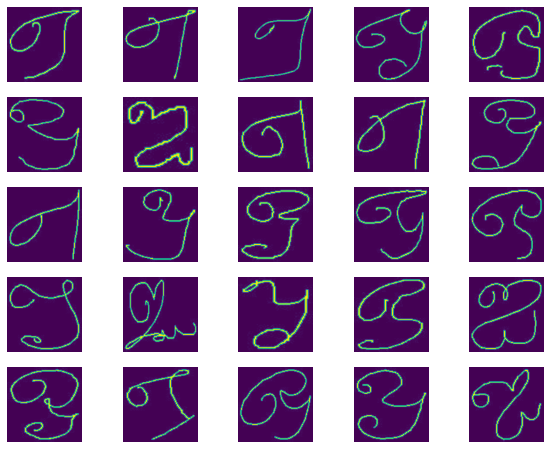

In [ ]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 5
columns = 5
  
fig = plt.figure(figsize=(10, 8))
j = 0
for i in range(0,25):
  img=X_test[i]
  j=j+1
  fig.add_subplot(rows, columns, j)
  img.shape=(128,128)
  plt.axis('off')
  plt.imshow(img)

In [ ]:
print("The predicted classes from Architecture 1: ",classpred1[0:25])
print("The predicted classes from Architecture 2: ",classpred2[0:25])
print("The predicted classes from Architecture 3: ",classpred3[0:25])
print("The predicted classes from Architecture 4: ",classpred4[0:25])
print("The predicted classes from Architecture 5: ",classpred5[0:25])

The predicted classes from Architecture 1:  ['ஏ', 'எ', 'ஏ', 'ஓ', 'ஓ', 'ஒ', 'ஐ', 'எ', 'எ', 'ஓ', 'எ', 'ஒ', 'ஓ', 'ஏ', 'ஒ', 'ஓ', 'ஐ', 'ஓ', 'ஒ', 'ஐ', 'ஓ', 'ஏ', 'ஒ', 'ஓ', 'ஐ']
The predicted classes from Architecture 2:  ['ஏ', 'ஏ', 'ஏ', 'ஓ', 'ஓ', 'ஒ', 'ஐ', 'எ', 'எ', 'ஓ', 'எ', 'ஒ', 'ஓ', 'ஒ', 'ஒ', 'ஓ', 'ஐ', 'ஓ', 'ஒ', 'ஐ', 'ஓ', 'ஓ', 'ஒ', 'ஓ', 'ஓ']
The predicted classes from Architecture 3:  ['ஏ', 'எ', 'ஏ', 'ஓ', 'ஓ', 'ஒ', 'ஐ', 'எ', 'எ', 'ஓ', 'எ', 'ஓ', 'ஓ', 'ஓ', 'ஓ', 'ஓ', 'ஐ', 'ஓ', 'ஓ', 'ஐ', 'ஓ', 'ஏ', 'ஓ', 'ஓ', 'ஓ']
The predicted classes from Architecture 4:  ['ஏ', 'ஏ', 'ஏ', 'ஏ', 'ஓ', 'ஒ', 'ஐ', 'எ', 'எ', 'ஓ', 'எ', 'ஒ', 'ஓ', 'ஏ', 'ஒ', 'ஓ', 'ஐ', 'ஓ', 'ஒ', 'ஐ', 'ஓ', 'ஏ', 'ஒ', 'ஓ', 'ஐ']
The predicted classes from Architecture 5:  ['ஏ', 'எ', 'ஏ', 'ஓ', 'ஓ', 'ஒ', 'ஐ', 'எ', 'எ', 'ஓ', 'எ', 'ஒ', 'ஓ', 'ஒ', 'ஒ', 'ஓ', 'ஐ', 'ஓ', 'ஒ', 'ஐ', 'ஓ', 'ஏ', 'ஓ', 'ஒ', 'ஐ']
